<a href="https://colab.research.google.com/github/DanielFelipe0915/Pokedex/blob/main/EDA_clasif_CVRdata_RNA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis datos pacientes riesgos cardiovascular

_Autor: Elias Buitrago B._

Maestría en Analítica de Datos


Modificado por: Daniel Galeano

Ingeniero de Sistemas

Universidad ECCI

In [ ]:
# Requirements
# conda install openpyxl
# conda install -c anaconda python-graphviz
# conda install -c anaconda pydot
# pip install xgboost
# pip install shap

## Cargar librerías

In [ ]:
# Load Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import process_time


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as split

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import utils as np_utils

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import metrics
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import graphviz
from sklearn.model_selection import cross_val_score, KFold

## Cargar datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# %% # Load data
# 5894 regitros
# 263 registros con datos faltantes de "Clasificación de RCV Global"
# 4 clases de RCV: 0, 1, 2, 3
# Tipos de RCV: Bajo, Intermedio, Alto, Muy Alto
data = pd.read_excel("/content/drive/MyDrive/data/pacientes_rcv_limpio.xlsx")
target = data.loc[:, 'Clasificación de RCV Global'].astype(int)
data = data.drop(['Clasificación de RCV Global'], axis=1)

target=pd.Categorical(target).codes

## Análisis de Correlación
Teniendo en cuenta que se está tratando con un probemas de clasificación multivariado, se decide iniciar con un análisis de correlación múltiple. Así, será posible descartar variables altamente correlacionadas que puedan afectar el desempeño de los modelos de clasificación.

### Identificar variables correlacionadas al 95%
Se utiliza como criterio una correlación superior al 0.95 y se calcula la correlación para el conjunto de datos. Los resultados indican la ausencia de variables altamente correlacionadas.

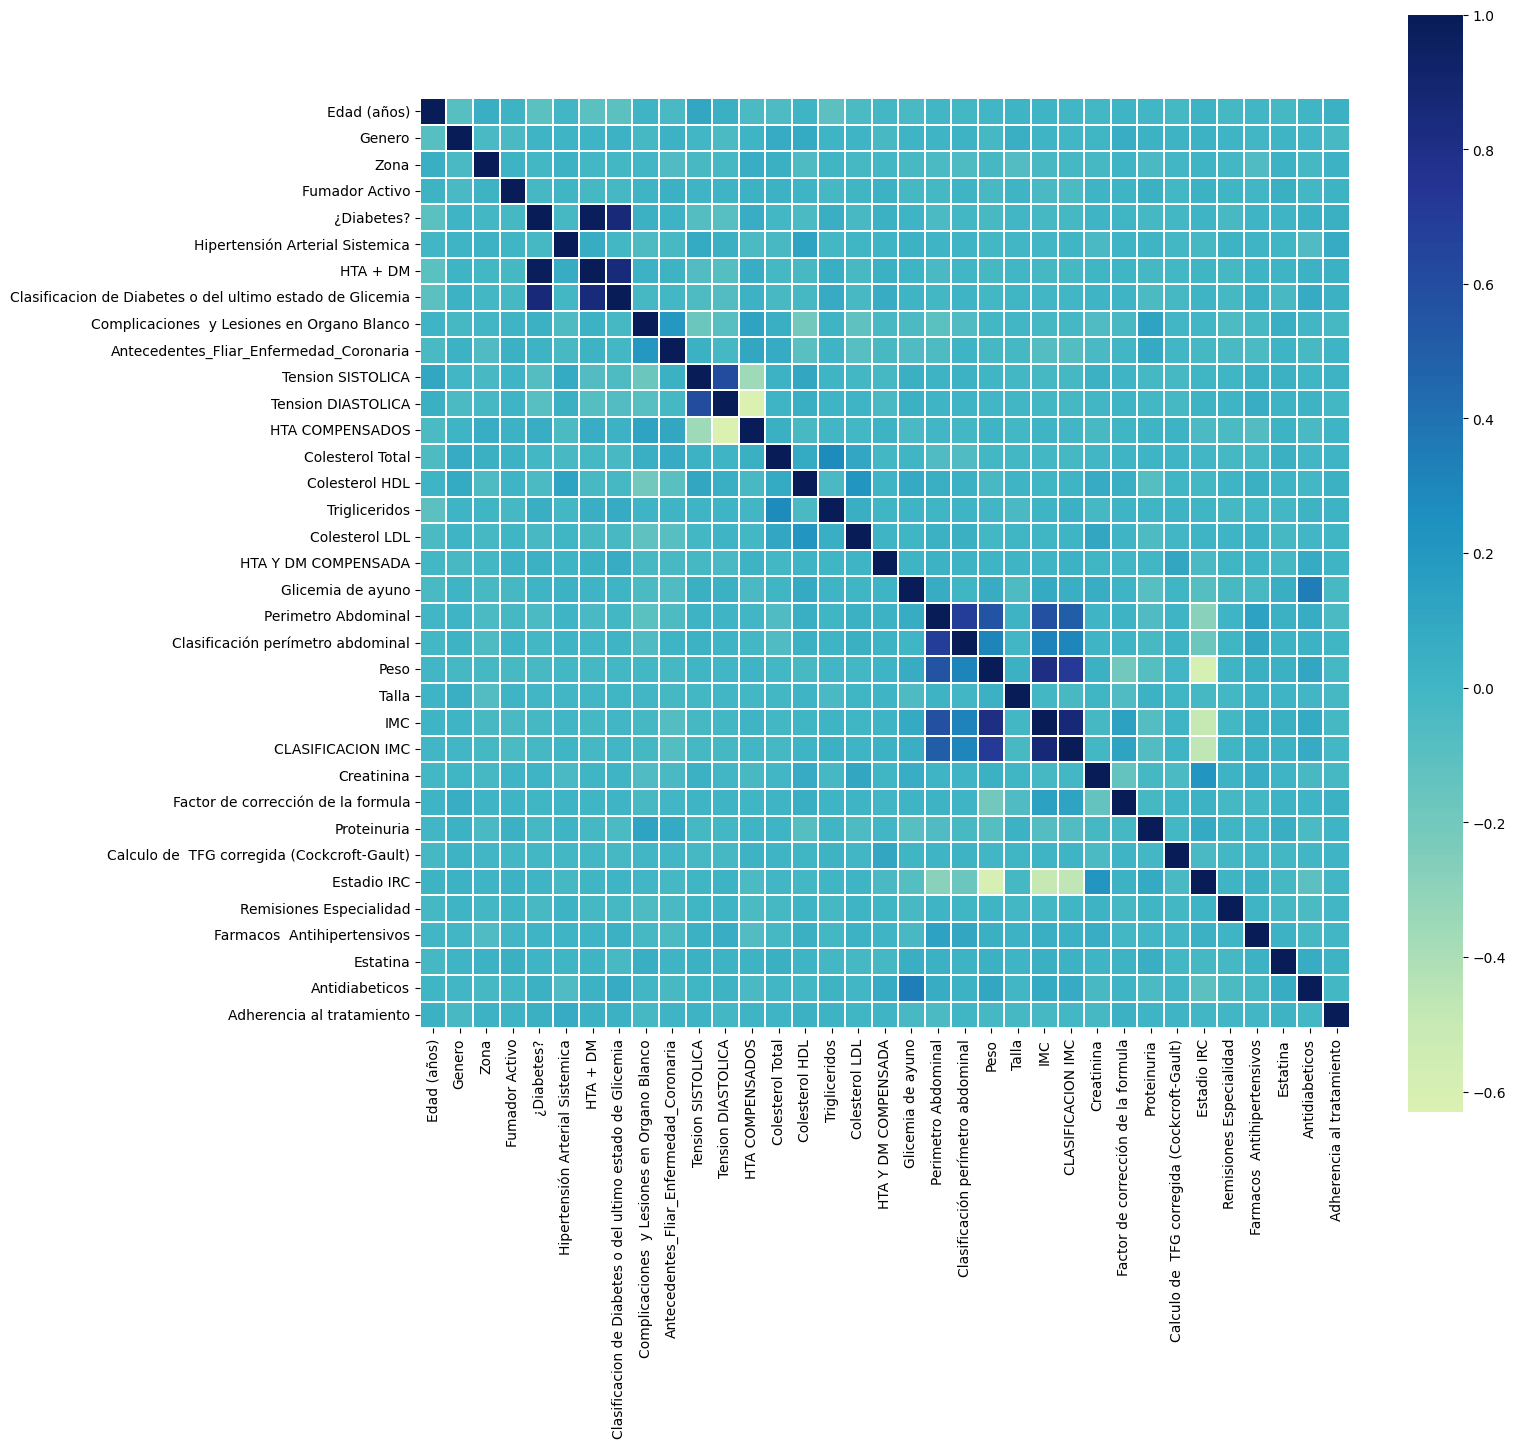

In [ ]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(15,15))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.2, annot=False, cbar_kws={"shrink": .95}
                )
    plt.show();

correlation_heatmap(data[np.array(data.columns)])

In [ ]:
#Crear la matriz de correlación
cor_matrix = data.corr().abs()

#Sleccionar el triángulo superior de la matriz de correlación
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))

#Identificar variables altamente correlacionadas (> 0.95)
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(to_drop)

['HTA + DM']


No se identifican variables altamente correlacionadas, por lo tanto se decide cambiar el criterio de correlación al 70%.

### Identificar variables correlacionadas al 70%
El gráfico de correlación muestra algunas variables que exhiben correlación fuerte, sin llegar a valores límite (-1, 1). Por lo tanto, se decide excluir las variables correlacionadas al 0.70. Aplicando este nuevo criterio, quedan excluidas las siguientes variables: HTA + DM, Clasificacion de Diabetes o del ultimo estado de Glicemia, IMC, CLASIFICACION IMC. De esta manera se obtiene un nuevo conjunto de datos con 31 variables.

In [ ]:
#Crear la matriz de correlación
cor_matrix = data.corr().abs()

#Sleccionar el triángulo superior de la matriz de correlación
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))

#Identificar variables altamente correlacionadas (> 0.70)
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.70)]
print(to_drop)

['HTA + DM', 'Clasificacion de Diabetes o del ultimo estado de Glicemia', 'IMC', 'CLASIFICACION IMC']


## Eliminar variables correlacionadas


In [ ]:
data_no_corr = data.drop(data[to_drop], axis=1)
name_vars = data_no_corr.columns
print(data_no_corr.shape)

### Reducir conjunto de datos basado en variables importantes halladas en el experimento previo

In [ ]:

imp_features_names=np.array(['Edad (años)','Colesterol HDL', 'Genero','Colesterol Total',
                             'Antecedentes_Fliar_Enfermedad_Coronaria',
                             'Tension SISTOLICA','Trigliceridos',
                             'Colesterol LDL'
                           ])
imp_features_idx=np.array([0,12,1,11,7,8,13,14])

imp_features = data_no_corr.columns[imp_features_idx]
data2 = data_no_corr[data_no_corr.columns[imp_features_idx]]
data2.shape
feature_cols=np.array(data2.columns)
feature_cols

## Modelos de clasificación para el conjunto de datos completo

### Particionar datos

In [ ]:
# Definir función para particionar el conjunto de datos
def particionar_datos(datos):
    ##transformar datos
    sc = StandardScaler()
    Xsc = sc.fit(datos)
    X = Xsc.transform(datos)
    X.shape
    ##
    X_train, X_test, y_train, y_test = split(X,target,
                                             test_size=0.30,
                                             random_state=42,
                                             stratify=target)
    X_train, X_valid, y_train, y_valid = split(X_train, y_train,
                                               test_size=0.2,
                                               stratify=y_train)
    ##
    print(X_train.shape, X_test.shape, X_valid.shape)
    print(y_train.shape, y_test.shape, y_valid.shape)

    return X_train, X_test, X_valid, y_train, y_test, y_valid

In [ ]:
#Particionar datos
X_train1, X_test1, X_valid1, y_train1, y_test1, y_valid1 = particionar_datos(data2)

#Transformación de datos requerida para RNA
Y_train1 = np_utils.to_categorical(y_train1)
Y_test1 = np_utils.to_categorical(y_test1)
Y_valid1 = np_utils.to_categorical(y_valid1)

### Redes Neuronales

#### Declaración de funciones para RNA

In [ ]:
# Definir función para construir RNA
def construrna():
    #Contruir RNA
    model = models.Sequential()
    model.add(layers.Dense(16, activation='tanh'))
    model.add(layers.Dense(16,  activation='tanh'))
    model.add(layers.Dense(16, activation='tanh'))
    # model.add(layers.Dropout(0.2))
    model.add(layers.Dense(16, activation='tanh'))
    model.add(layers.Dense(8, activation='tanh'))
    model.add(layers.Dense(3, activation='softmax'))

# compile the keras (tensorflow) flow graph
    model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


# Definir función para entrenar RNA
def trainrna(model, epo, batch,partial_x_train,partial_y_train,x_val,y_val):
    history = model.fit(partial_x_train,
                        partial_y_train,
                        epochs=epo,
                        batch_size=batch,
                        validation_data=(x_val, y_val),
                        verbose=0)
    return history

In [ ]:
# Definir función para la gráficas de pérdidas en entrenamiento y validación
def graf_perdidas_rna(history_rna):
    loss = history_rna.history['loss']
    val_loss = history_rna.history['val_loss']
    epochs = range(1, len(val_loss) + 1)
    # Gráfica comparativa: pérdida en entrenamiento
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'g*--', label="Perceptrón 5 capas")
    plt.title('Pérdida en el entrenamiento arquitectura ARN')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend(loc="upper center", fontsize="small")
    plt.legend()
    plt.grid(True)

    # gráfica comparativa: pérdida en validación
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_loss, 'b*--', label="Perceptrón 5 capas")
    plt.title('Pérdida en la validación arquitectura ARN')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend(loc="upper center", fontsize="small")
    plt.legend()
    plt.grid(True)
    plt.show()
    return

In [ ]:
# Métricas de desempeño
def metricas_rna(model_rna, X_test, Y_test):

#     # Exactitud
#     test_loss, test_acc = model.evaluate(X_test, Y_test)# testeo de la red con los de prueba
#     print('\nExactitud evaluación:',test_acc)
    Y_pred = model_rna.predict_classes(X_test, batch_size=32, verbose=1)
    Y_pred = np_utils.to_categorical(Y_pred)

    # predict_x=model.predict(X_test)
    # classes_x=np.argmax(predict_x,axis=1)

    # Mostrar la precisión, recall, F1-score
    print("\n", metrics.classification_report(Y_test, Y_pred, digits=3))

    return Y_pred

In [ ]:
# Matriz de confusión
def matriz_confusion(Y_test,Y_pred,RNA,titulo):
    if RNA == 'si':
        cm = metrics.confusion_matrix(Y_test.argmax(axis=1),
                                      Y_pred.argmax(axis=1))
    else:
        cm = metrics.confusion_matrix(Y_test, Y_pred)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['RCV bajo','RCV latente', 'RCV alto']
    plt.title(titulo)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    for i in range(3):
        for j in range(3):
            plt.text(j,i, str(cm[i][j]))
    return cm

In [ ]:
# Curva ROC
# #https://stackabuse.com/understanding-roc-curves-with-python/
def plot_roc_curve(Y_test, Y_pred, titulo):
    auc = roc_auc_score(Y_test, Y_pred)
    fpr, tpr, threshold = metrics.roc_curve(Y_test[:,0], Y_pred[:,0])
    font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }
    plt.plot(fpr, tpr, color='green', label='ROC RCV bajo')
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Postivos')
    plt.title(titulo)
    fpr, tpr, threshold = metrics.roc_curve(Y_test[:,1], Y_pred[:,1])
    plt.plot(fpr, tpr, color='darkblue', label='ROC RCV latente')
    fpr, tpr, threshold = metrics.roc_curve(Y_test[:,2], Y_pred[:,2])
    plt.plot(fpr, tpr, color='orange', label='ROC RCV alto')
    plt.text(0.7, 0.55, 'AUC: %.2f' % auc, fontdict=font)
    plt.legend()
    plt.show()

#### Crear modelo RNA, entrenamiento y métricas

In [ ]:
# Inicializar el reloj para calcular tiempo de cómputo
t_start = process_time()

# Construir la red neuronal
model_rna1 = construrna()

# Entrenar la red neuronal
history_rna1 = trainrna(model_rna1, 150, 32, X_train1,Y_train1,X_valid1,Y_valid1)

# Tiempo de computo
t_stop = process_time()
tc1 = t_stop-t_start

#Imprimir tiempo de cómputo
print('El tiempo de cómputo con RNA fue: %.2f segundos' % tc1)

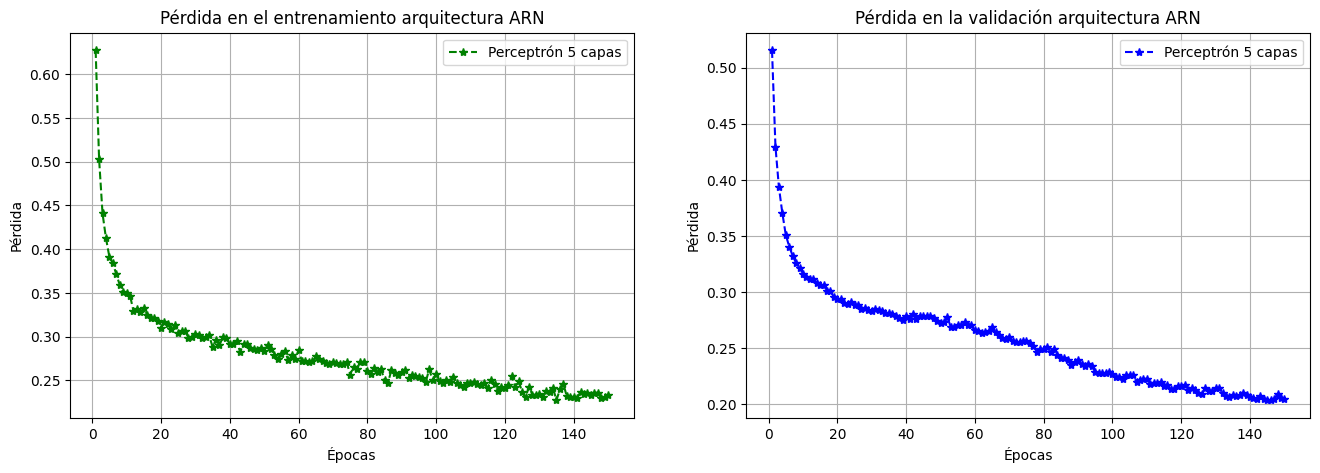

In [ ]:
# Gráficas de pérdidas
graf_perdidas_rna(history_rna1)

In [ ]:
# Calcular métricas de desempeño
Y_pred1 = metricas_rna(model_rna1, X_test1, Y_test1)

AttributeError: ignored

In [ ]:
# Matriz de confusión
cm1 = matriz_confusion(Y_test1,Y_pred1,'si','Matriz de confusión clasificador RNA')

NameError: ignored

In [ ]:
# Curva ROC
plot_roc_curve(Y_test1, Y_pred1, 'Curva ROC RNA')

NameError: ignored

In [ ]:
#Guardar modelo
model_rna1.save('modelClasif_rna.h5', history_rna1)
# from tensorflow.keras.models import load_model
# model = load_model('chatbot_model.h5',compile=False)

## Clasificación con clases balanceadas
Aunque los resultados de clasificación par alas variables más importantes son prometedores, se debe comentar unproblema que no se ha afrontado. Al realizar un conteo de clases del conjutno de datos de entrenamiento, se evidencia un desbalanceo de clases a favor de los pacientes con riesgo cardiovascular alto. Por lo tanto, en este sección se aplica un método se sobremuestreo para las otras dos clases (RCV bajo e intermedio) en el conjunto de datos de las variables más importantes. Posteriormente se entrenan los modelos y se comparan co los resultados mostrados sin el tratamiento del desbalance de clases.

### Conteo de clases
El desbalance de clases es notorio. La clase que representa al riesgo cardiovascular intermedio tiene 40% menos muestras que el riesgo cardiovascular alto. Entretanto, la clase que representa al riesgo cardiovascular bajo tiene 60% menos muestras que el riesgo cardiovascular alto.

In [ ]:
import pandas as pd
pd.DataFrame(y_train2).value_counts()

NameError: ignored

In [ ]:
#gráfico del conteo de clases

### Sobremuestreo para compensar desbalanceo de clases

In [ ]:
!pip install imblearn

In [ ]:
from imblearn.over_sampling import RandomOverSampler
over_sample = RandomOverSampler(sampling_strategy = 'all')
X_train2, y_train2 = over_sample.fit_resample(X_train1, y_train1)
X_test2, y_test2 = over_sample.fit_resample(X_test1, y_test1)
X_valid2, y_valid2 = over_sample.fit_resample(X_valid1, y_valid)


#Transformación de datos requerida para RNA
Y_train2 = np_utils.to_categorical(y_train2)
Y_test2 = np_utils.to_categorical(y_test2)
Y_valid2 = np_utils.to_categorical(y_valid2)

NameError: ignored

### Redes Neuronales

El tiempo de cómputo con RNA fue: 119.86 segundos


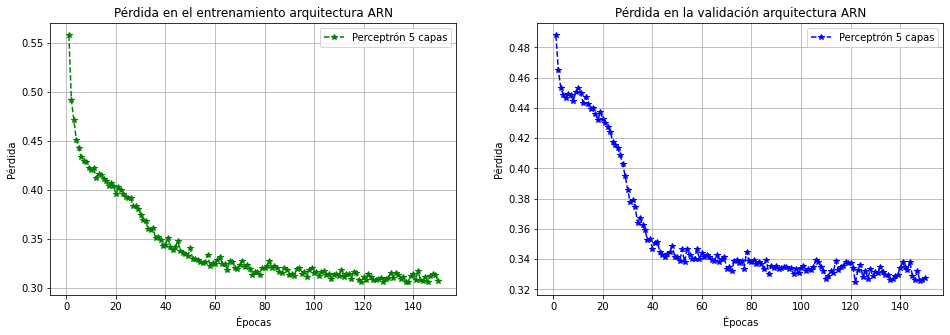

80/80 [==============================] - 0s 1ms/step

               precision    recall  f1-score   support

           0      0.839     0.846     0.842       844
           1      0.727     0.806     0.764       844
           2      0.886     0.783     0.831       844

   micro avg      0.812     0.812     0.812      2532
   macro avg      0.817     0.812     0.813      2532
weighted avg      0.817     0.812     0.813      2532
 samples avg      0.812     0.812     0.812      2532



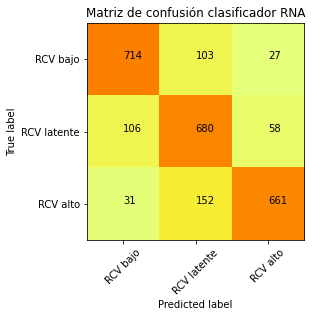

In [ ]:
# Inicializar el reloj para calcular tiempo de cómputo
t_start = process_time()

# Construir la red neuronal
model_rna3 = construrna()

# Entrenar la red neuronal
history_rna3 = trainrna(model_rna3, 150, 32, X_train3,Y_train3,X_valid3,Y_valid3)

# Tiempo de computo
t_stop = process_time()
tc11 = t_stop-t_start

#Imprimir tiempo de cómputo
print('El tiempo de cómputo con RNA fue: %.2f segundos' % tc11)

# Gráficas de pérdidas
graf_perdidas_rna(history_rna3)

# Calcular métricas de desempeño
Y_pred31 = metricas_rna(model_rna3, X_test3, Y_test3)

# Matriz de confusión
cm11 = matriz_confusion(Y_test3,Y_pred31,'si','Matriz de confusión clasificador RNA')

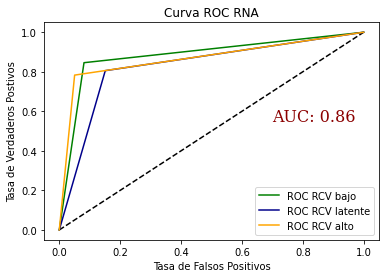

In [ ]:
# Curva ROC
plot_roc_curve(Y_test3, Y_pred31, 'Curva ROC RNA')

In [ ]:
#Guardar modelo
model_rna3.save('elison_rna3.h5', history_rna3)
# from tensorflow.keras.models import load_model
# model = load_model('elison_rna3.h5',compile=False)

NameError: name 'elison_rna3' is not defined

## Conclusiones
Aunque se reduce considerablemente el conjunto de datos inicial, hasta el punto de tener un subconjunto con las 8 variables má importantes, para llevarlas al chatbot puede pasar que el usuario final no tenga a la mano cada uno de los datos requeridos para que el modelo predictivo funcione. Por ejemplo, el valor del colesterol o triglicéridos. Ante este nuevo escenario se podrían plantear nuevos experimentos para evluar la predicción de riesgo cardiovascular a partir de muy pocas variables como _Edad (años),Genero y Antecedentes_Fliar_Enfermedad_Coronaria_. Sin embargo, esto reduciría notablemente el poder de predicción de Elison.

## Referencias